# 1 Knapsack Problem

The knapsack problem is one of the most trivial NP-hard problems. We can encounter many of its variants in the literature, which generally have various solution requirements for the algorithm. The formulation always contains criterium for the overall price, which means it is an optimization problem.

## 1.1 Author of Report

* **Name:** Tomáš Patro
* **Username:** patrotom
* **Email:** patrotom@fit.cvut.cz

## 1.2 Base of Problem

We are given

* integer $n$ (number of items)
* integer $M$ (capacity of knapsack)
* finite set $V = \{v_1, v_2, \dots, v_n\}$ (weights of items)
* finite set $C = \{c_1, c_2, \dots, c_n\}$ (prices of items)


## 1.3 Decision 0/1 Problem Form

In this task, we will solve a decision problem form, which is one of the variants with some specific requirements:

In addition to the input variables we define

* positive integer $B$ (minimal required price)

We say that the problem has a solution if we can find a set $X=\{x_1, x_2, \dots, x_n\}$ where each $x_i$ is either $0$ or $1$, and

$v_1x_1 + v_2x_2 + \dots + v_nx_n \le M$ (knapsack is not overloaded), and

$c_1x_1 + c_2x_2 + \dots + c_nx_n \ge B$ (price is greater or equal to required price).

<br>

<cite data-cite="6752554/CXL66Z59"></cite>

# 2 Solution approaches


In the following section, we will describe two basic approaches (algorithms) to solve this problem:

* Brute force
* Branch and bound (B&B)

Both algorithms compute the optimal price and the configuration (vector of $n$-bits). The vector is equivalent to the set $X$ described in the **section 1.2**. We decide whether the problem is solvable by comparing the optimal price and the minimal required price $B$. The problem is solvable if the resulting price meets the requirements described in the **section 1.2**.

In both of the algorithms, we use recursion to search the state space.

## 2.1 Brute Force

In the brute force approach, we search (almost) the whole state space to find the optimal price and configuration. The truth is that we do not go through the entire state space – that's why almost. We add a simple condition that cuts the recursion branch if adding an item would result in the overloaded knapsack.

Let us look at the code snippet of the algorithm:

``` python
def brute_force(conf, i, weight, price):
    if i == instance.size:
        solution.complexity += 1
        if price >= solution.price:
            solution.price = price
            solution.weight = weight
            solution.conf = conf
        return

    new_weight = instance.items[i].weight + weight

    conf[i] = 1
    if new_weight <= instance.capacity:
        new_price = instance.items[i].price + price
        brute_force(conf, i + 1, new_weight, new_price)

    conf[i] = 0
    brute_force(conf, i + 1, weight, price)
```

The algorithm starts by comparing the current depth of the recursion `i` with the size of the instance. We use to comparison to determine if we have already solved one of the branches of recursion. We increment the counter of the complexity – we later use this data in the analysis. If the `price` is greater or equal to the current optimal price, we update the `solution` object with the new values – `price`, `weight`, and vector configuration `conf`.

Next, we compute a new weight by adding the current weight to the particular items' weight. To cover the whole state space, we have to call the recursion with the current bit set to either $0$ or $1$. We also have to recalculate the price and weight. We later send them the recursion if the bit is set to $1$ – it means that the item is added to the knapsack. Also, as mentioned above, we call the recursion with the added item only if the recalculated weight is less than or equal to the capacity of the knapsack – we don't overload the knapsack.

The algorithm searches (almost) the entire state space and correctly computes the optimal price. The configuration, weight, and optimal price are stored in the `solution` object. We further use this objects' data in the **section 3** (analysis) and to answer the question of whether a particular instance is solvable or not.

## 2.2 Branch and Bound (B&B)

The beginning of the B&B algorithm is the same as in the brute force algorithm. The only difference is in the second condition for the cutting of the recursion calls (state space). Let us look at the difference in the algorithm:

``` python
def branch_and_bound(conf, i, weight, price):
    # The first condition is same as in the brute force algorithm...
    
    new_weight = instance.items[i].weight + weight
    new_price = instance.items[i].price + price
    upper_bound = price + instance.prices_sum(i=i)

    conf[i] = 1
    if (new_weight <= instance.capacity) and (upper_bound >= solution.price):
        branch_and_bound(conf, i + 1, new_weight, new_price)

    conf[i] = 0
    branch_and_bound(conf, i + 1, weight, price)
```

We enhance the condition by checking if the current `price` added to the sum of prices of the unvisited items (on the index `i` and greater) is greater or equal to the current optimal price. We can cut the recursion branch if we do not meet this condition. This way, we cut the branches of the state space, which do not lead us to the optimal price.

# 3 Results Analysis


We analyze the data using the *Python* language and its mathematical modules. The graphs and the whole report are rendered in the *Jupyter Notebook* – that's why we also add the code snippets in this report, which process data and generate the graphs. Data generated by the solution code are stored in the CSV format files, so we can easily load and process them.

We start by loading and processing the data:

In [1]:
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [27]:
# Helper functions

def bar_plot(ax, data, colors=None, total_width=0.8, single_width=1, legend=True):
    if colors is None:
        colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

    n_bars = len(data)
    bar_width = total_width / n_bars
    bars = []

    for i, (name, values) in enumerate(data.items()):
        x_offset = (i - n_bars / 2) * bar_width + bar_width / 2
        for x, y in enumerate(values):
            bar = ax.bar(x + x_offset, y, width=bar_width * single_width, color=colors[i % len(colors)])
            height = bar[0].get_height()
            ax.annotate('{}'.format(height),
                        xy=(bar[0].get_x() + bar[0].get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom')
        
        bars.append(bar[0])

    if legend:
        ax.legend(bars, data.keys())

def complexity_graph(clxs, ax, version="mean"):
    data = {
    "B&B (NR)": clxs["NR"]["bb"],
    "Brute Force (NR)": clxs["NR"]["bf"],
    "B&B (ZR)": clxs["ZR"]["bb"],
    "Brute Force (ZR)": clxs["ZR"]["bf"]
    }
    
    labels = ["4", "10", "15", "20", "22"]
    x = np.arange(len(labels))

    prefix = "Average" if version == "mean" else "Maximal" 

    ax.set_title(f"{prefix} complexity by instance size")

    ax.set_ylabel("Complexity")
    ax.set_xlabel("Instance size")
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    plt.yscale("log")

    bar_plot(ax, data, total_width=.8, single_width=.9)
    
def time_graph(times, ax, version="mean"):
    data = {
    "B&B (NR)": times["NR"]["bb"],
    "Brute Force (NR)": times["NR"]["bf"],
    "B&B (ZR)": times["ZR"]["bb"],
    "Brute Force (ZR)": times["ZR"]["bf"]
    }
    
    labels = ["4", "10", "15", "20", "22"]
    x = np.arange(len(labels))
    
    prefix = "Average" if version == "mean" else "Maximal" 

    ax.set_title(f"{prefix} execution time by instance size")

    ax.set_ylabel("Execution time [ms]")
    ax.set_xlabel("Instance size")
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    plt.yscale("log")

    bar_plot(ax, data, total_width=.8, single_width=.9)

In [16]:
data = {"NR": {"bb": {}, "bf": {}}, "ZR": {"bb": {}, "bf": {}}}
c_means = {"NR": {"bb": [], "bf": []}, "ZR": {"bb": [], "bf": []}}
c_maxes = copy.deepcopy(c_means)
clxs = copy.deepcopy(c_means)
t_means = copy.deepcopy(c_means)
t_maxes = copy.deepcopy(c_means)

dtypes = {"solvable": bool, "conf": str, "price": int, "weight": int, "time": float, "complexity": int}

for v in ["NR", "ZR"]:
    for t in ["bb", "bf"]:
        for n in [4, 10, 15, 20, 22]:
            df = pd.read_csv(f"../data/output/{v}/{t}/{v}{n}_out.csv", sep=";", dtype=dtypes )
            c_means[v][t].append(df.complexity.mean())
            c_maxes[v][t].append(df.complexity.max())
            t_means[v][t].append(float("{:.2f}".format(df.time.mean() * 1000)))
            t_maxes[v][t].append(float("{:.2f}".format(df.time.max() * 1000)))
            if n == 20:
                clxs[v][t] = df.complexity

## 3.1 Complexity Analysis

First, we look at the dependency between the size of the instance $n$ and the complexity of the computation. Complexity is defined as the number of the evaluated configurations of the $n$-bit vector. In the first graph, we take the **average complexity** of the instances:

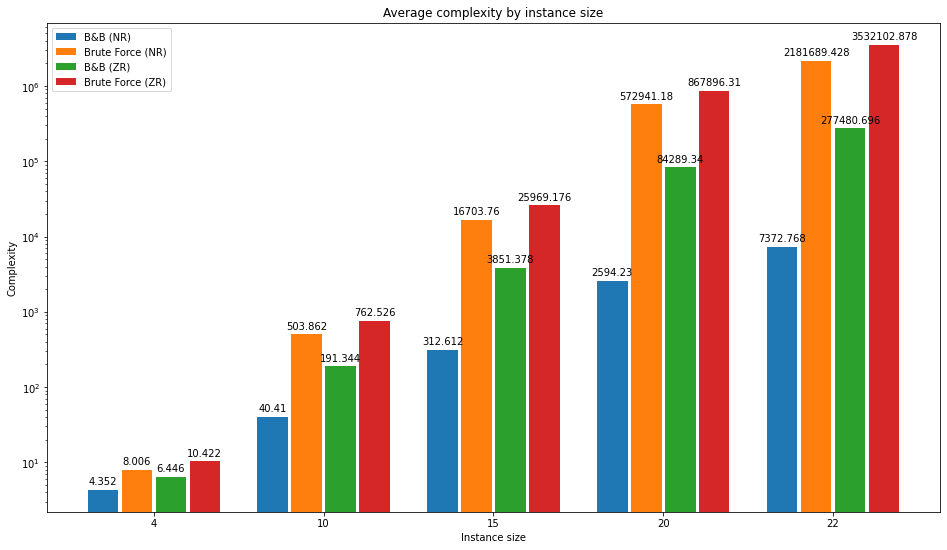

In [29]:
fig, ax = plt.subplots()
complexity_graph(c_means, ax)
plt.rcParams['figure.figsize'] = (16, 9)
plt.show()

From the graph above, we can see a strong dependency between an instance's size and the average complexity of the computation. We can also note that the B&B algorithm successfully cut parts of the state space and lowered overall average complexity compared to the brute force version.

Another observation we can make is that **ZR** data set is slightly more complex to solve than the **NR** data set for the brute force version. For the B&B version, the difference is even more significant. We can conclude that the **ZR** data set is more difficult to solve than the **NR** data set. We can also conclude that the B&B algorithm has an overall lower complexity than the brute force algorithm.

We can also take a look at a similar graph where we replace the average complexity with the maximal complexity for a particular instance size:

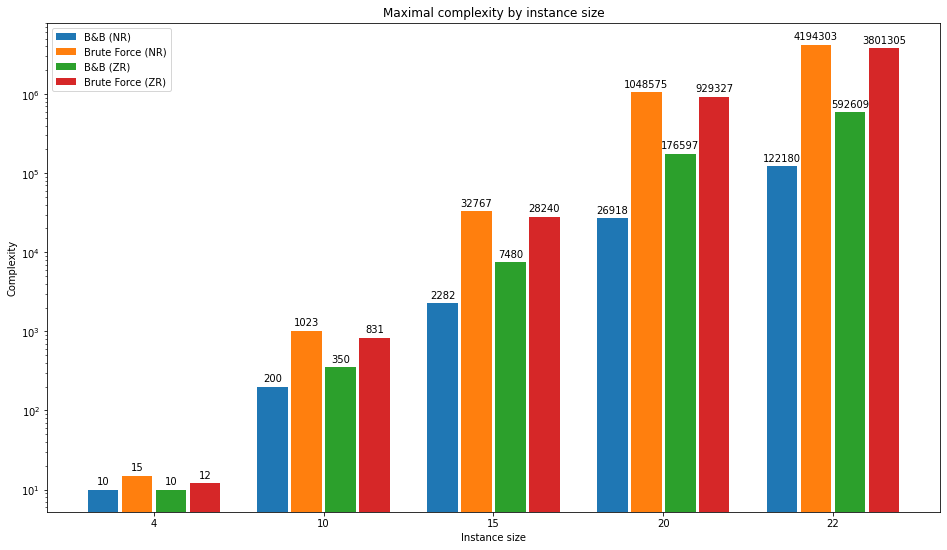

In [28]:
fig, ax = plt.subplots()
complexity_graph(c_maxes, ax, version="max")
plt.show()

Interestingly, maximal complexity is higher in the **NR** data set than in the **ZR** data set for the brute force version. There is a more complex problem to solve for all instance sizes in the **NR** data set than in the **ZR** data set. On the other hand, we can see that B&B is more successful in the state space cutting in the **NR** data set than in the **ZR** data set.

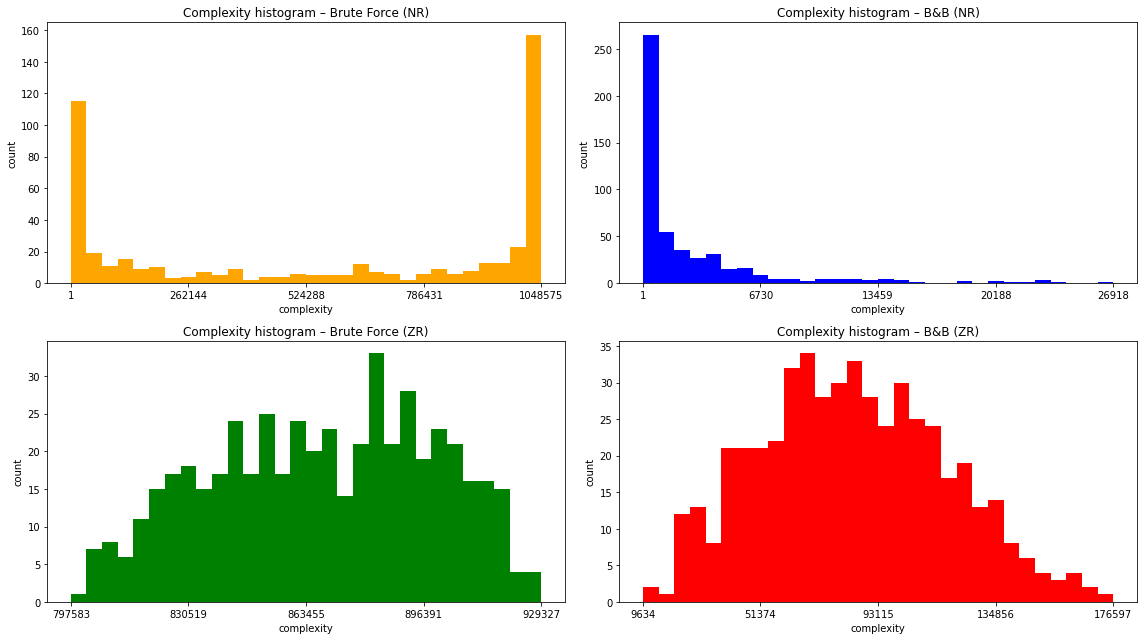

In [6]:
fig, axs = plt.subplots(2, 2, tight_layout=True)

for i in [0, 1]:
    for j in [0, 1]:
        axs[i][j].set_xlabel("complexity")
        axs[i][j].set_ylabel("count")
        axs[i][j].ticklabel_format(style="plain")

axs[0][0].set_title("Complexity histogram – Brute Force (NR)")
axs[0][0].hist(clxs["NR"]["bf"], bins=30, color="orange")
x = np.linspace(start=min(clxs["NR"]["bf"]), stop=max(clxs["NR"]["bf"]), num=5, dtype=int)
axs[0][0].set_xticks(x)

axs[0][1].set_title("Complexity histogram – B&B (NR)")
axs[0][1].hist(clxs["NR"]["bb"], bins=30, color="blue")
x = np.linspace(start=min(clxs["NR"]["bb"]), stop=max(clxs["NR"]["bb"]), num=5, dtype=int)
axs[0][1].set_xticks(x)

axs[1][0].set_title("Complexity histogram – Brute Force (ZR)")
axs[1][0].hist(clxs["ZR"]["bf"], bins=30, color="green")
x = np.linspace(start=min(clxs["ZR"]["bf"]), stop=max(clxs["ZR"]["bf"]), num=5, dtype=int)
axs[1][0].set_xticks(x)

axs[1][1].set_title("Complexity histogram – B&B (ZR)")
axs[1][1].hist(clxs["ZR"]["bb"], bins=30, color="red")
x = np.linspace(start=min(clxs["ZR"]["bb"]), stop=max(clxs["ZR"]["bb"]), num=5, dtype=int)
axs[1][1].set_xticks(x)

plt.show()

From the above histograms, we can see a higher frequency of a lower complexity using the B&B version and the NR data set. The brute force version frequently has either low or high complexity using the NR data set. We can assume that the brute force version starts to be ineffective once we reach a defined size $n$ of an instance or encounter a complex configuration. On the other hand, the B&B version successfully cuts the state space for most instance sizes and configurations of the knapsack.

The algorithms behave in a different manner using the ZR data set. We can see that the complexities have an almost normal distribution. We can assume that the ZR data sets' configuration complexities may come from a normal distribution.

## 3.2 Execution Time Analysis

We measured the execution time for each run of the algorithm and saved the data to the CSV files. The execution time was measured using the Python `timeit` module, which measures CPU time. The times you see in the graphs are represented in milliseconds.

Computer configuration:

* **CPU:** Intel(R) Core(TM) i5-8265U CPU @ 1.60GHz
* **OS:** Linux Mint 19.2
* **Linux kernel:** 5.4.0-48-generic 


We can use this data to see how is the execution time affected by the version of the algorithm, and the instance size $n$. First, let's look at the average execution times:

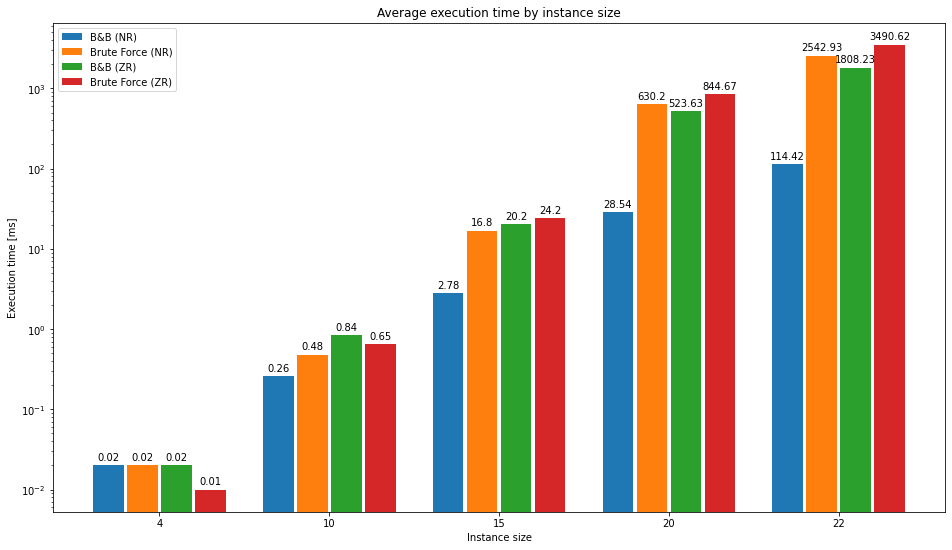

In [32]:
fig, ax = plt.subplots()
time_graph(t_means, ax)
plt.show()

From the graph above, we can see that the execution time grows exponentially. We experimentally confirmed $O(2^n)$ complexity of the algorithm. We can see that the B&B version lowers the execution time on most of the instance sizes. The difference is more significant using the NR data set. We can also confirm that, even though the B&B version speeds up the execution time, the version still has $O(2^n)$ complexity.

Let's take a look at the same graph, but using the maximal execution times:

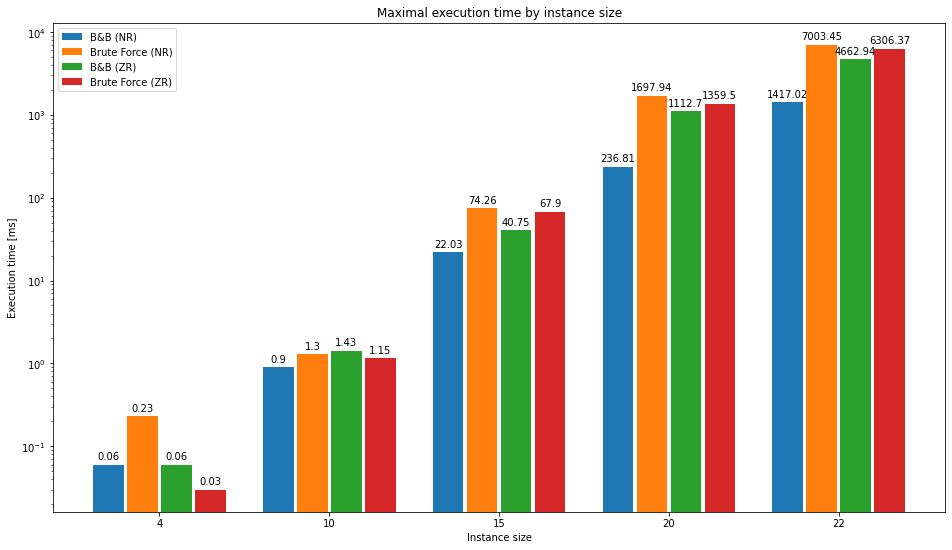

In [33]:
fig, ax = plt.subplots()
time_graph(t_maxes, ax, version="max")
plt.show()

We can see that the maximal graph is similar to the average graph. It experimentally again confirms the algorithms' $O(2^n)$ complexity.

# 4 Conclusion

TODO


# Bibliography

<br>

<div class="cite2c-biblio"></div>